In [197]:
from skimage import io
from skimage.color import rgb2gray, rgba2rgb, gray2rgb
from skimage.exposure import equalize_hist
from skimage.filters import threshold_sauvola, gaussian, threshold_otsu
from skimage.morphology import binary_closing, skeletonize, erosion, white_tophat, black_tophat, square, binary_opening, remove_small_holes
from skimage.measure import find_contours
from skimage.transform import resize
from skimage.feature import hog
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pprint

# Utilities

In [2]:
def show_with_contours(image, contours, title=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')

    for contour in contours:
        min_row, min_col = int(min(contour[:, 0])), int(min(contour[:, 1]))
        max_row, max_col = int(max(contour[:, 0])), int(max(contour[:, 1]))

        rect_height = max_row - min_row
        rect_width = max_col - min_col

        rectangle = plt.Rectangle((min_col, min_row), rect_width, rect_height,
                                  edgecolor='green', linewidth=1, facecolor='none')
        plt.gca().add_patch(rectangle)

    plt.axis('off')
    if title is not None:
        plt.title('Rectangles around Contours')
    plt.show()

In [3]:
def show_with_contours_dict(image, contours_dict, title=None, axes=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')

    for c in contours_dict:
        rectangle = plt.Rectangle((c["x"][1], c["y"][1]), c["w"], c["h"],
                                  edgecolor='green', linewidth=2, facecolor='none')
        plt.gca().add_patch(rectangle)

    plt.axis('off')
    if title is not None:
        plt.title('Rectangles around Contours')
    plt.show()

In [4]:
def show_plate_chars(char_list):
    fig, axes = plt.subplots(1, len(char_list))
    for i, char in enumerate(char_list):
        axes[i].imshow(char, cmap="gray")
        axes[i].axis("off")
    plt.show()

In [5]:
## extracting the hog
def extract_hog_features(img):
    if img.dtype == "bool":
        img = np.where(img,255,0).astype(np.uint8)
    img = cv2.resize(img, (32,32))
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

# Testing an image

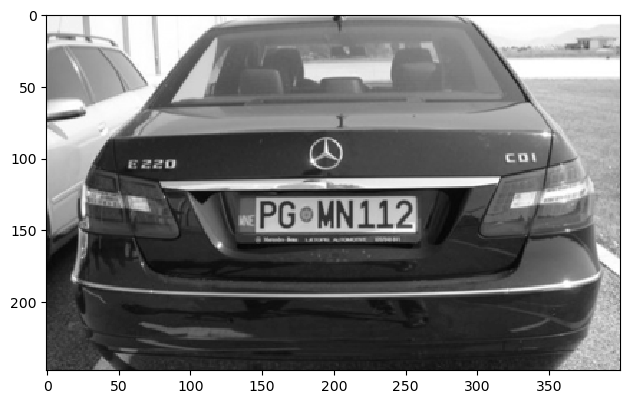

In [156]:
img = io.imread('dataset/images/Cars1.png', as_gray=True)
io.imshow(img)
io.show()

# Preprocess

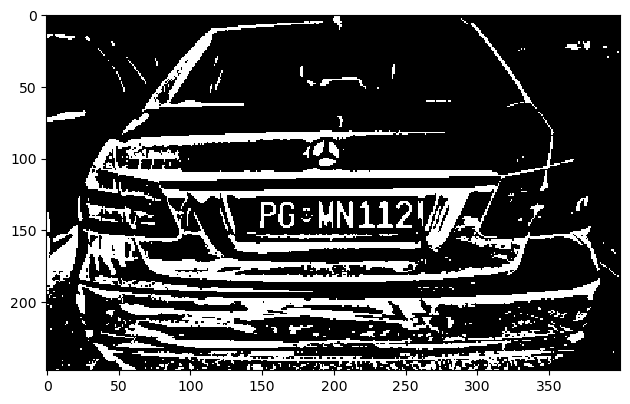

In [157]:
def preprocess(img):
    new_img = equalize_hist(img) # enhance contrast
#     new_img = gaussian(img) # smooth image
    new_img = new_img < threshold_sauvola(new_img) # thresholding
#     new_img = binary_opening(new_img) # remove small noise
    return new_img

img = preprocess(img)
io.imshow(img)
io.show()

# Get Contours

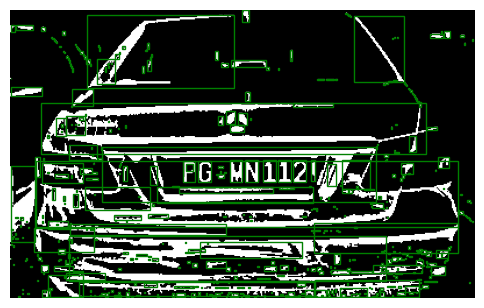

In [158]:
def get_contours(img):
    contours_dict = []
    contours = find_contours(img)

    for contour in contours:
        min_row, min_col = int(min(contour[:, 0])), int(min(contour[:, 1]))
        max_row, max_col = int(max(contour[:, 0])), int(max(contour[:, 1]))

        rect_height = max_row - min_row
        rect_width = max_col - min_col

        ratio = 99999
        if rect_height != 0:
            ratio = rect_width/rect_height

        contours_dict.append({"area": rect_height*rect_width, "w/h": ratio, "y": (
            max_row, min_row), "x": (max_col, min_col), "h": rect_height, "w": rect_width})
    return contours, contours_dict

contours, contours_dict = get_contours(img)
show_with_contours(img, contours)

# 1st Filter

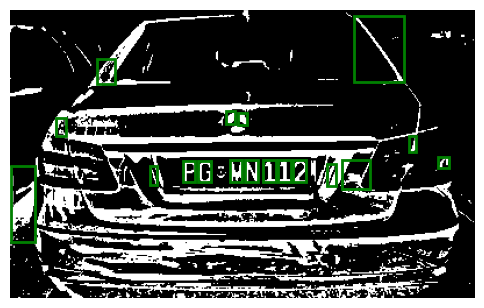

In [183]:
def filter_size(contours_dict):
    AREA_THRESHOLD = 74
    WIDTH_THRESHOLD = 2
    HEIGHT_THRESHOLD = 7
    MIN_RATIO = 0.16
    MAX_RATIO = 1

    filtered_contours_dict = []

    for c in contours_dict:
        if c['area'] > AREA_THRESHOLD and c["w"] > WIDTH_THRESHOLD and c['h'] > HEIGHT_THRESHOLD and MIN_RATIO < c['w/h'] < MAX_RATIO:
            filtered_contours_dict.append(c)

    filtered_contours_dict = sorted(filtered_contours_dict, key=lambda x: x['x'][0]) # sort the contours based from left tot right
    return filtered_contours_dict

filtered_contours_dict = filter_size(contours_dict)
show_with_contours_dict(img, filtered_contours_dict)

# 2nd Filter

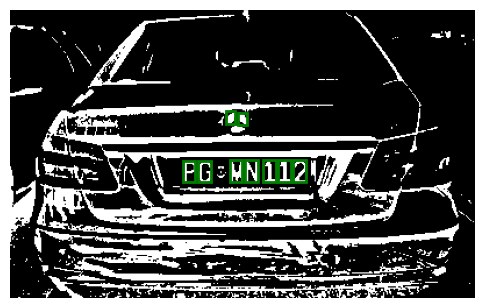

In [169]:
def filter_alignment(filtered_contours_dict):
    W_THRESHOLD = 0.8
    H_THRESHOLD = 0.2
    ANGLE_THRESHOLD = np.radians(12)
    AREA_DIFF_THRESHOLD = 1
    DIAGONAL_THRESHOLD = 1.1

    final_contours = []

    for c1 in filtered_contours_dict:
        diagonal = (c1["w"] ** 2 + c1["h"] ** 2)**0.5
        for c2 in filtered_contours_dict:
            if c1 == c2: # make sure they're different contours
                continue

            dx = abs(c1['x'][0] - c2['x'][0]) # x difference
            dy = abs(c1['y'][0] - c2['y'][0]) # y difference

            if dx == 0 or np.arctan(dy/dx) > ANGLE_THRESHOLD: # filter based on  angle
                continue

            if abs(c1["area"] - c2["area"]) / c1["area"] > AREA_DIFF_THRESHOLD or abs(c1["w"] - c2["w"]) / c1["w"] > W_THRESHOLD or abs(c1["h"] - c2["h"]) / c1["h"] > H_THRESHOLD or dx > diagonal * DIAGONAL_THRESHOLD:
                continue

            final_contours.append(c2)

    final_contours = [dict(t)
                      for t in {tuple(sorted(d.items())) for d in final_contours}]
    
    final_contours = sorted(final_contours, key=lambda x: x['x'][0]) # sort the contours based from left tot right
    return final_contours

final_contours = filter_alignment(filtered_contours_dict)
show_with_contours_dict(img, final_contours)

# 3rd Filter

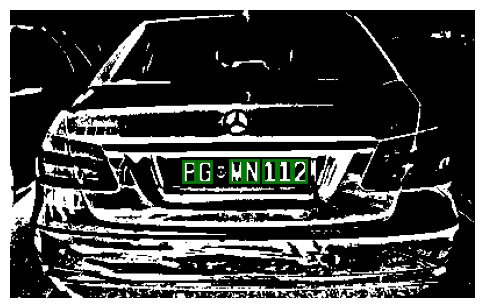

[ { 'area': 198,
    'h': 18,
    'w': 11,
    'w/h': 0.6111111111111112,
    'x': (159, 148),
    'y': (148, 130)},
  { 'area': 198,
    'h': 18,
    'w': 11,
    'w/h': 0.6111111111111112,
    'x': (172, 161),
    'y': (148, 130)},
  { 'area': 190,
    'h': 19,
    'w': 10,
    'w/h': 0.5263157894736842,
    'x': (199, 189),
    'y': (148, 129)},
  { 'area': 209,
    'h': 19,
    'w': 11,
    'w/h': 0.5789473684210527,
    'x': (213, 202),
    'y': (148, 129)},
  { 'area': 209,
    'h': 19,
    'w': 11,
    'w/h': 0.5789473684210527,
    'x': (228, 217),
    'y': (148, 129)},
  { 'area': 209,
    'h': 19,
    'w': 11,
    'w/h': 0.5789473684210527,
    'x': (241, 230),
    'y': (148, 129)},
  { 'area': 209,
    'h': 19,
    'w': 11,
    'w/h': 0.5789473684210527,
    'x': (254, 243),
    'y': (148, 129)}]


In [182]:
def filter_position(filtered_contours_dict):
    DIAGONAL_THRESHOLD = 1
    H_THRESHOLD = 0.2
    
    final_contours = []
    
    for c1 in filtered_contours_dict:
        left = 0
        right = 0
        
        
        for c2 in filtered_contours_dict:
            if c1 == c2: # make sure they're different contours
                continue
            
            dx = abs(c1['x'][0] - c2['x'][0]) # x difference
            dy = abs(c1['y'][0] - c2['y'][0]) # y difference
            
            if abs(c1["h"] - c2["h"]) / c1["h"] > H_THRESHOLD: # make sure they're on the same line
                continue
                
            diag = (dx**2 + dy**2) **0.5
            if dx < 2 * DIAGONAL_THRESHOLD * diag:
                if c1['x'][0] > c2['x'][0]:
                    left += 1
                else:
                    right += 1
            
            if left >= 2 or right >= 2:
                final_contours.append(c1)
                break
            pass
        
    final_contours = sorted(final_contours, key=lambda x: x['x'][0]) # sort the contours based from left tot right
    return final_contours


final_contours = filter_position(final_contours)
show_with_contours_dict(img, final_contours)
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(final_contours)

# Crop with padding

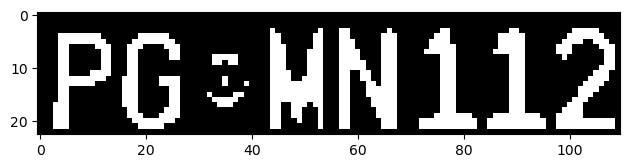

In [171]:
def crop_pad(img, final_contours, PADDING=2):
    min_x = [d["x"][1] for d in final_contours]
    min_y = [d["y"][1] for d in final_contours]

    max_x = [d["x"][0] for d in final_contours]
    max_y = [d["y"][0] for d in final_contours]

    min_x = np.min(min_x)
    min_x = 0 if (min_x - PADDING < 0) else min_x - PADDING
    min_y = np.min(min_y)
    min_y = 0 if (min_y - PADDING < 0) else min_y-PADDING

    max_x = np.max(max_x)
    max_x = img.shape[1] if (max_x + PADDING > img.shape[1]) else max_x+PADDING
    max_y = np.max(max_y)
    max_y = img.shape[0] if (max_y + PADDING > img.shape[0]) else max_y+PADDING

#     print(min_y, min_x)
#     print(max_y, max_x)

    cropped = img.copy()
    cropped = cropped[min_y:max_y, min_x:max_x]
    return cropped

cropped = crop_pad(img, final_contours)
io.imshow(cropped, cmap="gray")
io.show()

# Filter Plate Only

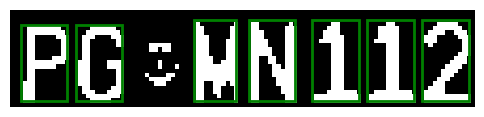

In [184]:
cropped_cont, cropped_cont_dict = get_contours(cropped)
cropped_filter_size = filter_size(cropped_cont_dict)
# cropped_filter_alignment = filter_alignment(cropped_filter_size)

show_with_contours_dict(cropped, cropped_filter_size)

# Extract Characters

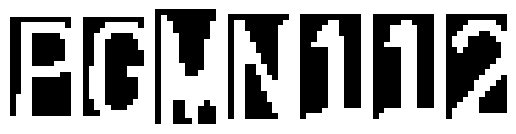

In [209]:
def get_chars(cropped, cropped_filtered):
    chars_img = []
    for char in cropped_filtered:
        left = char["x"][1]
        right = char["x"][0]
        top = char["y"][1]
        bottom = char["y"][0]
    
        cropped_char = cropped[top:bottom, left:right]
        
#         cropped_morph_char = binary_opening(cropped_char)
#         cropped_morph_char = binary_closing(cropped_char) # TODO: character level filtering here
        cropped_morph_char = remove_small_holes(cropped_char,5) # TODO: character level filtering here

#         cropped_resized_char = resize(cropped_morph_char, (32, 32))
        chars_img.append(cropped_morph_char)
    
    return chars_img

chars_list = get_chars(cropped, cropped_filter_size)

show_plate_chars(chars_list)

# Extraction Function

In [406]:
# TODO: will be changed from the roots
def plate_extractor(img):
    img = gaussian(img)
    img = equalize_hist(img)
    img = img < threshold_sauvola(img)

    contours_dict = []
    contours = find_contours(img)

    for contour in contours:
        min_row, min_col = int(min(contour[:, 0])), int(min(contour[:, 1]))
        max_row, max_col = int(max(contour[:, 0])), int(max(contour[:, 1]))

        rect_height = max_row - min_row
        rect_width = max_col - min_col

        ratio = 99999
        if rect_height != 0:
            ratio = rect_width/rect_height

        contours_dict.append({"area": rect_height*rect_width, "w/h": ratio, "y": (
            max_row, min_row), "x": (max_col, min_col), "h": rect_height, "w": rect_width})

    AREA_THRESHOLD = 80
    WIDTH_THRESHOLD = 2
    HEIGHT_THRESHOLD = 7
    MIN_RATIO = 0.25
    MAX_RATIO = 1

    filtered_contours_dict = []

    for c in contours_dict:
        if c['area'] > AREA_THRESHOLD and c["w"] > WIDTH_THRESHOLD and c['h'] > HEIGHT_THRESHOLD and MIN_RATIO < c['w/h'] < MAX_RATIO:
            filtered_contours_dict.append(c)

    W_THRESHOLD = 0.8
    H_THRESHOLD = 0.2
    ANGLE_THRESHOLD = np.radians(12)
    AREA_DIFF_THRESHOLD = 1
    DIAGONAL_THRESHOLD = 1

    final_contours = []

    for c1 in filtered_contours_dict:
        diagonal = (c1["w"] ** 2 + c1["h"] ** 2)**0.5
        for c2 in filtered_contours_dict:
            if c1 == c2:
                continue

            dx = abs(c1['x'][0] - c2['x'][0])
            dy = abs(c1['y'][0] - c2['y'][0])

            if dx == 0 or np.arctan(dy/dx) > ANGLE_THRESHOLD:
                continue

            if abs(c1["area"] - c2["area"]) / c1["area"] > AREA_DIFF_THRESHOLD or abs(c1["w"] - c2["w"]) / c1["w"] > W_THRESHOLD or abs(c1["h"] - c2["h"]) / c1["h"] > H_THRESHOLD or dx > diagonal * DIAGONAL_THRESHOLD:
                continue

            final_contours.append(c2)

    final_contours = [dict(t)
                      for t in {tuple(sorted(d.items())) for d in final_contours}]
    
    show_with_contours_dict(img,final_contours)
    

    min_x = [d["x"][1] for d in final_contours]
    min_y = [d["y"][1] for d in final_contours]

    max_x = [d["x"][0] for d in final_contours]
    max_y = [d["y"][0] for d in final_contours]

    PADDING = 1

    min_x = np.min(min_x)
    min_x = 0 if (min_x - PADDING < 0) else min_x - PADDING
    min_y = np.min(min_y)
    min_y = 0 if (min_y - PADDING < 0) else min_y-PADDING

    max_x = np.max(max_x)
    max_x = img.shape[1] if (max_x + PADDING > img.shape[1]) else max_x+PADDING
    max_y = np.max(max_y)
    max_y = img.shape[0] if (max_y + PADDING > img.shape[0]) else max_y+PADDING

    cropped = img.copy()
    cropped = cropped[min_y:max_y, min_x:max_x]
    cropped = binary_opening(cropped)

    plate = find_contours(cropped)

    plate_dict = []
    for contour in plate:
        min_row, min_col = int(min(contour[:, 0])), int(min(contour[:, 1]))
        max_row, max_col = int(max(contour[:, 0])), int(max(contour[:, 1]))

        rect_height = max_row - min_row
        rect_width = max_col - min_col

        plate_dict.append({"area": rect_height*rect_width, "y": (
            max_row, min_row), "x": (max_col, min_col), "h": rect_height, "w": rect_width})

    area_median = np.median([char["area"]
                            for char in plate_dict])  # if char["area"] > 20
    h_median = np.median([char["h"] for char in plate_dict if char["h"] > 50])

    chars = [char for char in plate_dict if char["area"]
             >= area_median or char["h"] >= h_median]

    chars_img = []
    for char in chars:
        chars_img.append(cropped[char["y"][1]:char["y"]
                                 [0], char["x"][1]:char["x"][0]])

    for i in range(len(chars_img)):
        chars_img[i] = resize(chars_img[i], (32, 32))

    return chars_img, cropped, chars

# Test Extraction

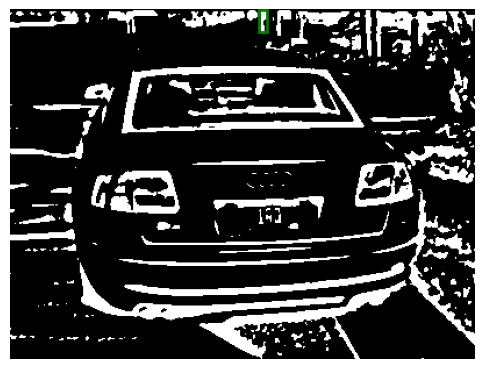

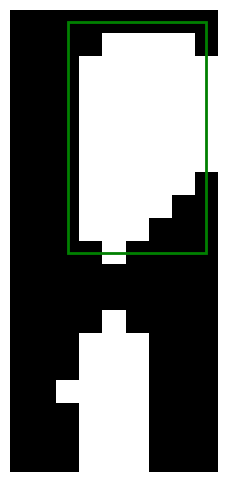

In [407]:
img1 = io.imread('dataset/images/Cars21.png', as_gray=True)
chars_img, cropped, chars = plate_extractor(img1)
show_with_contours_dict(cropped, chars)

# Save Symbols

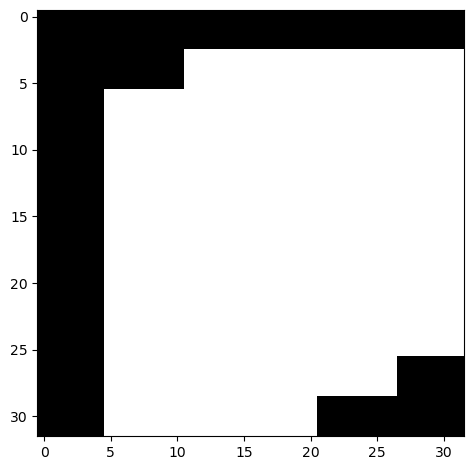

In [408]:
for i, imgX in enumerate(chars_img):

    io.imshow(imgX)
    io.show()
#     io.imsave(fname=f"test12{i}.png", arr=imgX)

# Load OCR

In [28]:
OCR = pickle.load(open('modelKNN.OCR','rb'))

# Extract Features

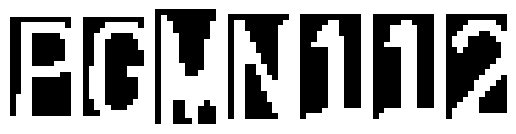

In [210]:
test_features = []

for image in chars_list:
    test_char = np.copy(image)
    test_features.append(extract_hog_features(test_char))
    pass

show_plate_chars(chars_list)

In [211]:
OCR.predict(test_features)

array(['P', 'C', 'W', 'N', '1', '1', '2'], dtype='<U1')

In [213]:
OCR.predict_proba([test_features[2]])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0.]])